# RAG関連手法の学習 - 1. Query Transformation
* https://python.langchain.com/docs/concepts/#retrieval

In [6]:
from dotenv import load_dotenv
import os
from PIL import Image
# 環境変数読み込み
load_dotenv()

# 画像表示関数
def show_image(path):
    im = Image.open(path)
    return im

True

## 1. Query Transformation (質問文の整形)
* DBに検索かける前に、検索で情報が引っ掛かりやすくなるように、LLMを使って質問文をいい具合に整形する手法

### 整形手法
1. Multi-Query
    * 様々な角度から質問文をカバーしたいとき利用。多様な視点から複数の関連する質問文を作る。
    * https://python.langchain.com/docs/how_to/MultiQueryRetriever/
    * https://www.youtube.com/watch?v=JChPi0CRnDY
2. Decomposition
    * 質問文をさらに詳細な質問文に分解する。
    * https://www.youtube.com/watch?v=h0OPWlEOank
3. Step-back
    * 元の質問文からより一般的(抽象的)な質問文を生成し、その質問文による検索結果も追加情報として付与する。
    * https://arxiv.org/pdf/2310.06117
4. HyDE
    * 元の質問文に対する仮の回答をLLMで作成し、その回答で検索を行うことで、より文脈に沿った情報をDBより抽出する。
    * https://arxiv.org/abs/2212.10496


### 1-1. Multi-Query
* https://www.youtube.com/watch?v=JChPi0CRnDY

In [122]:
### Data indexing and reservation for LLM-based multi-query

# Load blog
import bs4
from langchain_community.document_loaders import WebBaseLoader

blog_path = "https://www.nri.com/jp/knowledge/blog/lst/2024/fis/kiuchi/1003_3"
loader = WebBaseLoader(
    web_paths=(blog_path,),
    # bs_kwargs=dict(
    #     parse_only=bs4.SoupStrainer(
    #         class_=("post-content", "post-title", "post-header")
    #     )
    # ),
)
blog_docs = loader.load()

# Split
from langchain.text_splitter import RecursiveCharacterTextSplitter
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=300,
    chunk_overlap=50,
    separators=["\n\n", "。", "、", "\n", "！", "？", "；", "：", "「", "」", "『", "』", "（", "）", "・", "…", "　"],
)

splits = text_splitter.split_documents(blog_docs)

# Index
from langchain_openai import OpenAIEmbeddings
from langchain_community.vectorstores import Chroma
vectorestore = Chroma.from_documents(
    documents=splits,
    embedding=OpenAIEmbeddings()
)

retriever = vectorestore.as_retriever()

In [123]:
# 記事のチャンク結果
for content in splits:
    text = content.page_content
    print(text.replace(" ", "").replace("\n", ""))
    print("--------------------")

石破首相が所信表明へ：岸田路線の継承が鮮明に：日銀利上げへの慎重発言と円安の影響｜2024年|木内登英のGlobalEconomy&PolicyInsight|野村総合研究所(NRI)ナレッジ・インサイトソリューション・サービスサステナビリティニュース企業情報株主・投資家情報(IR)採用情報ナレッジ・インサイトトップ刊行物書籍コラムセミナー資料レポート用語解説
--------------------
刊行物書籍コラムセミナー資料レポート用語解説ソリューション・サービストップマネジメントコンサルティングシステムコンサルティング金融ITソリューション産業ITソリューションIT基盤サービスソリューション・製品・サービスお客様事例未来創発センターサステナビリティトップサステナビリティ経営マテリアリティへの取り組みライブラリニューストップニュースリリースお知らせイベント企業情報トップ社長メッセージ
--------------------
お知らせイベント企業情報トップ社長メッセージ企業理念経営ビジョンコーポレート・ガバナンス会社概要国内・海外拠点株主・投資家情報(IR)トップIRニュースIRイベント経営方針財務・業績IRライブラリ株式・格付情報個人投資家の皆さまへナレッジ・インサイトナレッジ・インサイトトップ刊行物書籍コラムセミナー資料レポート用語解説ソリューション・サービス
--------------------
ソリューション・サービスソリューション・サービストップマネジメントコンサルティングシステムコンサルティング金融ITソリューション産業ITソリューションIT基盤サービスソリューション・製品・サービスお客様事例未来創発センターサステナビリティサステナビリティトップサステナビリティ経営マテリアリティへの取り組みライブラリニュースニューストップニュースリリースお知らせイベント企業情報企業情報トップ社長メッセージ企業理念経営ビジョンコーポレート・ガバナンス会社概要国内・海外拠点
--------------------
株主・投資家情報(IR)株主・投資家情報(IR)トップIRニュースIRイベント経営方針財務・業績IRライブラリ株式・格付情報個人投資家の皆さまへ採用情報未来へのヒントが見つかるイノベーションマガジン未来を見通し、未来を創り出すNRIのプロフェッショナル

In [124]:
### 追加質問のprompt
from langchain.prompts import ChatPromptTemplate

# Multi-query prompt
# promptに複数の質問文を生成するように指示する
template = """You are an AI language model assistant. Your task is to generate five different versions of the given user question
 to retrieve the relevant documents from a vector database. By generating multiple perspectives on the user question, your goal
 is to help the user overcome some of the limitations of the distance-based similarity search.
 Question is  wrriten in Japanese. So answer in Japanese.
 Provide these alternative questions separated by newlines. Original question: {question}"""

prompt_perspectives = ChatPromptTemplate.from_template(template)

from langchain_core.output_parsers import StrOutputParser
from langchain_openai import ChatOpenAI

generate_queries = (
    prompt_perspectives
    | ChatOpenAI(temperature=0)
    | StrOutputParser()
    | (lambda x: x.split("\n"))
)

In [125]:
# multi-queryによる追加質問例
question = "利上に対する総理の考えは？"
generated_queries = generate_queries.invoke(question)

print(f"元の質問: {question}\n")
print("生成された追加質問文:")
for x in range(len(generated_queries)):
    print(f"{str(x+1)}. {generated_queries[x]}")


元の質問: 利上に対する総理の考えは？

生成された追加質問文:
1. 1. 総理の見解は、利上に対してどうでしょうか？
2. 2. 利上に関する総理の見解は何ですか？
3. 3. 総理は利上についてどのように考えていますか？
4. 4. 利上に関する総理の意見を教えてください。
5. 5. 総理は利上についてどんな考えを持っていますか？


In [126]:
### 質問の生成と回答

from langchain.load import dumps, loads
# dumpでlangchainの型をシリアライズして、loadsでそれを復元する

def get_unique_union(documents: list[list]):
    """ Unique union of retrieval docs """
    # flatted list of lists, and convert each Document to string
    flattened_docs = [dumps(doc) for sublist in documents for doc in sublist]
    # 外側loop: for sublist in documents、内側loop: for doc in sublistの2重loopを一つにしたもの

    # Get unique documents
    unique_docs = list(set(flattened_docs))

    return [loads(doc) for doc in unique_docs]


# Retrieve
retrieval_chain = generate_queries | retriever.map() | get_unique_union
docs = retrieval_chain.invoke(question)
print(len(docs))

4


In [131]:
# vectore storeからの検索結果
print("-vector storeからの検索結果: -\n")
for doc in docs:
    print(doc.page_content.replace(" ", "").replace("\n", ""))
    print()

-vector storeからの検索結果: -

石破首相が自民党総裁選に勝利した直後に利上げ観測から円高が進み、株価が大きく下落したことが新政権へダメージになるとの危機感が、こうした発言の背景にある可能性が考えられる。また、目先に迫る衆院選挙に向けた短期集中型の政策アピール、という側面もあるかもしれない。ただし、こうした発言を受けて再び円安が進むと、物価上昇圧力も高まり、国民生活を圧迫しかねない。この点から、石破政権が追加利上げに慎重な姿勢を強調することが、果たして選挙に有利に働くのかどうかについては不明確だ。そして、石破政権の基本的な政策スタンスは、選挙を終えてからでないと明確には読めないと考えられる。

。年内に利上げするのは政治的時間が短い上に国民からの理解を得るのも困難であるとし、想定している12月会合での追加利上げの確度はやや低下したのではないかと述べた。

岸田前政権の「構造的賃上げ」の継承が重要石破首相は所信表明演説で、政策全体の方針としては、総裁選を通じて示してきたように、「ルール」「日本」「国民」「地方」「若者・女性の機会」の５つを守り、日本の未来を創り、未来を守ると主張する。そのうえで、経済政策では、１）物価高の影響を受ける低所得者世帯への支援、２）新たな地方創生施策を展開、３）中堅・中小企業の賃上げ環境整備、４）成長力に資する国内投資促進、５）石川県能登半島など自然災害からの復旧・復興、を挙げる見通しだ。

選挙を睨んだ戦略かこうした石破首相の発言は、金融緩和の長期化がもたらす弊害を指摘する従来の見解からはやや修正された印象もあるが、方針が大きく修正されたのかどうかについては、まだ慎重に見極める必要があるだろう。現時点での発言は、目先の総選挙を強く意識したものである可能性が高いとみられるからだ。まずは、選挙に勝ち、政権基盤を固めることが、石破政権の最優先課題なのだろう。



In [132]:
### Q&A

from operator import itemgetter
from langchain_openai import ChatOpenAI
from langchain_core.runnables import RunnablePassthrough

# RAG
template = """
As a economist, answer the follwoing question in Japanease based on this context. context and Question are written in Japanese.:

{context}

Question: {question}
"""

prompt = ChatPromptTemplate.from_template(template)

llm = ChatOpenAI(temperature=0)

final_rag_chain = (
    {"context": retrieval_chain,
     "question": itemgetter("question")}
    | prompt
    | llm
    | StrOutputParser()
)

final_ans = final_rag_chain.invoke({"question": question})

In [133]:
# Q&A結果確認
def print_jp(response):
    sentence = ""
    for r in response:
        sentence += r
        if r == "。":
            print(sentence)
            sentence = ""

print(question,':\n')
print_jp(final_ans)

利上に対する総理の考えは？ :

総理の考えは、利上げに慎重な姿勢を示しており、政治的な要素や国民生活への影響を考慮していると言えます。
選挙を意識した発言や金融緩和の弊害を指摘する見解から方針が修正された可能性もあるが、現時点では慎重に見極める必要があるとされています。


### 1-2. Decomposition
* https://www.youtube.com/watch?v=h0OPWlEOank

In [134]:
from langchain.prompts import ChatPromptTemplate

# Decomposition prompt
template = """You are a helpful assistant that generates multiple sub-questions related to an input question.
 The goal is to break dwon the input into a set of sub-problems / sub-questions that can be answers in isolation.
 question is written in Japanese. So answer in Japanese.
 Generate multiple search queries related to: {question}
 Output (3 queries):"""

prompt_decomposition = ChatPromptTemplate.from_template(template)

In [135]:
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser

# LLM
llm = ChatOpenAI(temperature=0)

# Chain
generate_queries_decomposition = (
    prompt_decomposition
    | llm
    | StrOutputParser()
    | (lambda x: x.split("\n"))
    )

# Run-追加質問の生成
question = "利上に対する総理の考えは？"
questions = generate_queries_decomposition.invoke({"question": question})

In [136]:
print(f"元のquestion: {question}\n")
print("生成されたquestions:")
questions

元のquestion: 利上に対する総理の考えは？

生成されたquestions:


['1. 利上に対する総理の具体的な政策は何か？',
 '2. 総理が利上に対して取り組む予定の施策は何か？',
 '3. 利上に関する総理の過去の発言や行動はどのようなものがあるか？']

#### * Answer recursively


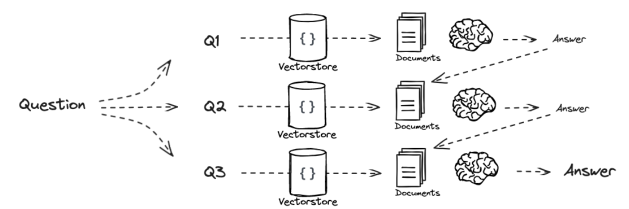

In [174]:
im = show_image("./data/decomposition.png")
im

In [137]:
# Prompt
template = """Here is the question you need to answer. Those questions are written in Japanese:
\n --- \n {question} \n --- \n
Here is any available background question + answer pairs:
\n --- \n {q_a_pairs} \n --- \n
Here is additional context relevant to the question:
\n --- \n {context} \n --- \n
Use the above context and any background question + answer pairs to answer the question in Japanease: \n {question}
"""

decomposition_prompt = ChatPromptTemplate.from_template(template)

In [140]:
from operator import itemgetter
from langchain_core.output_parsers import StrOutputParser

def format_qa_pair(question, answer):
    """ Format Q and A pair """
    formatted_string = ""
    formatted_string += f"Question: {question}\nAnswer: {answer}\n\n"
    return formatted_string.strip()

# LLM
llm = ChatOpenAI(model_name="gpt-4o-mini", temperature=0)

q_a_pairs = ""
for q in questions:

    rag_chain = (
        {"context": itemgetter("question") | retriever,
         "question": itemgetter("question"),
         "q_a_pairs": itemgetter("q_a_pairs")}
    | decomposition_prompt
    | llm
    | StrOutputParser()
    )

    answer = rag_chain.invoke({"question": q, "q_a_pairs": q_a_pairs})
    q_a_pair = format_qa_pair(q, answer)
    print(q_a_pair, '\n\n')
    q_a_pairs += q_a_pair + "\n\n" + q_a_pair


Question: 1. 利上に対する総理の具体的な政策は何か？
Answer: 石破首相の利上に対する具体的な政策は、主に以下の点に焦点を当てています：

1. **物価高の影響を受ける低所得者世帯への支援**：物価高の影響が特に大きい低所得者世帯に対して、支援策を強化することを重視しています。

2. **賃上げ環境の整備**：中堅・中小企業の賃上げを促進するための環境整備を行い、構造的賃上げを継承する方針です。

3. **国内投資の促進**：成長力を高めるために、国内投資を促進する施策を展開することが挙げられています。

これらの政策は、物価高や経済成長に対する対応策として位置づけられています。 


Question: 2. 総理が利上に対して取り組む予定の施策は何か？
Answer: 総理が利上に対して取り組む予定の施策は、以下のような点に焦点を当てています：

1. **物価高の影響を受ける低所得者世帯への支援**：物価高の影響が特に大きい低所得者世帯に対して、支援策を強化することを重視しています。

2. **賃上げ環境の整備**：中堅・中小企業の賃上げを促進するための環境整備を行い、構造的賃上げを継承する方針です。

3. **国内投資の促進**：成長力を高めるために、国内投資を促進する施策を展開することが挙げられています。

これらの施策は、物価高や経済成長に対する対応策として位置づけられています。また、総理は利上げに対して慎重な姿勢を示しており、年内の利上げ観測が後退していることも影響しています。政治的な時間が限られている中で、国民からの理解を得ることが難しいため、慎重に進める必要があるとされています。 


Question: 3. 利上に関する総理の過去の発言や行動はどのようなものがあるか？
Answer: 総理の利上に関する過去の発言や行動は、以下のような点が挙げられます。

1. **慎重な発言**：総理就任直後から、日本銀行の政策金利引き上げに対して慎重な姿勢を示しており、利上げに関する発言は控えめでした。この姿勢は、金融緩和の長期化による影響を考慮したものであると考えられます。

2. **岸田路線の継承**：所信表明演説では、岸田路線の継承を明確にし、利上げに対する慎重なアプローチを強調しました。これは、選挙を意識した戦略の一環と

In [141]:
print(f"元の質問: {question}\n")
print_jp(answer.replace(" ", "").replace("\n", ""))

元の質問: 利上に対する総理の考えは？

総理の利上に関する過去の発言や行動は、以下のような点が挙げられます。
1.**慎重な発言**：総理就任直後から、日本銀行の政策金利引き上げに対して慎重な姿勢を示しており、利上げに関する発言は控えめでした。
この姿勢は、金融緩和の長期化による影響を考慮したものであると考えられます。
2.**岸田路線の継承**：所信表明演説では、岸田路線の継承を明確にし、利上げに対する慎重なアプローチを強調しました。
これは、選挙を意識した戦略の一環とも見られています。
3.**経済成長と物価高への対応**：物価高の影響を受ける低所得者世帯への支援や、賃上げ環境の整備、国内投資の促進といった政策を通じて、利上げに対する影響を緩和しようとする姿勢が見られます。
4.**選挙を意識した発言**：総理の発言は、目先の総選挙を強く意識したものである可能性が高く、政権基盤を固めることが最優先課題とされています。
これらの発言や行動は、利上げに対する総理の慎重な姿勢を反映しており、経済状況や国民の理解を得ることを重視していることが伺えます。


#### * Answer individually

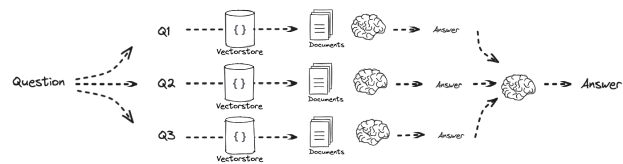

In [175]:
im = show_image("./data/decomposition_2.png")
im

In [151]:
### Answer each sub-question individually

from langchain_core.prompts import ChatPromptTemplate
from langchain_core.runnables import RunnablePassthrough, RunnableLambda
from langchain_core.output_parsers import StrOutputParser
from langchain_openai import ChatOpenAI

# LLM
llm = ChatOpenAI(model_name="gpt-4o-mini", temperature=0)


system_prompt = (
    "You are an economist."
    "Use the following pieces of retrieved context to answer the user's question. "
    "If you don't know the answer, say that you don't know.  Make consice and consistent sentences."
    "Question and retrieved context are Japanease. So answer in Japanese."
    "\n\n"
    "{context}"
)

prompt_rag = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        ("human", "{question}"),
    ]
)

def retrieve_and_rag(question, prompt_rag, sub_question_generator_chain):
    """RAG on each sub-question"""

    # Use our decomposition function to make sub-questions
    sub_questions = sub_question_generator_chain.invoke({"question": question})

    # Initialize a list to hold RAG chain results
    rag_results = []

    # Run RAG on each sub-question
    for sub_question in sub_questions:
        
        # Retrieve documents for each sub-question
        retrieved_docs = retriever.get_relevant_documents(sub_question)

        # Use retrieved documents and sub-question in RAG chain
        answer = (prompt_rag | llm | StrOutputParser()).invoke({"context": retrieved_docs, "question": sub_question})

        rag_results.append(answer)

    return rag_results, sub_questions

# Wrap the retrieval and RAG process in a RunnableLambda for integration into chain
answers, questions = retrieve_and_rag(question, prompt_rag, generate_queries_decomposition)

C:\Users\yoshi\AppData\Local\Temp\ipykernel_24752\594749727.py:38: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  retrieved_docs = retriever.get_relevant_documents(sub_question)


In [159]:
# 生成された各質問に対する回答
for q, a in zip(questions, answers):
    print(f"Question: {q}\nAnswer: ")
    print_jp(a)
    print()

Question: 1. 利上に対する総理の具体的な政策は何か？
Answer: 
石破首相は、物価高の影響を受ける低所得者世帯への支援を強調し、賃上げと投資がけん引する成長型経済の実現を掲げています。
また、最低賃金の全国平均1,500円を達成する時期の目標を2030年代半ばから2020年代に前倒しする方針を示しています。
さらに、中堅・中小企業の賃上げ環境整備や国内投資促進も重要な政策として挙げています。

Question: 2. 総理が利上に対して取り組む予定の施策は何か？
Answer: 
石破首相は利上げに対して慎重な姿勢を示しており、年内の利上げ観測が後退しています。
彼の発言は、金融政策の正常化を進める日本銀行に対して政治的な逆風があることを示唆しています。
具体的な施策についてはまだ明確ではなく、選挙を意識した戦略が優先されているため、今後の動向を慎重に見極める必要があります。

Question: 3. 利上に関する総理の過去の発言や行動はどのようなものがあるか？
Answer: 
石破首相は就任直後に日本銀行の政策金利引き上げに慎重な発言をしており、脱アベノミクスの色合いがやや後退した印象があります。
また、所信表明演説では岸田路線の継承を鮮明にする方向性を示しています。
これらの発言は、目先の総選挙を意識した戦略の一環と考えられ、金融緩和の長期化に伴う弊害についての従来の見解からはやや修正された印象もありますが、方針の大きな変更については慎重に見極める必要があります。



In [166]:
### 上記3つのquestionとanswerをまとめてRAGに投入し、元の質問に対する回答を得る

# context作成
def format_qa_pairs(questions, answers):
    """Format Q and A pairs """
    formatted_string = ""
    for i, (question, answer) in enumerate(zip(questions, answers), start=1):
        formatted_string += f"Question {i}: {question}\nAnswer: {answer}\n\n"

    return formatted_string.strip()

context = format_qa_pairs(questions, answers)


# Prompt
template = """Here is a set of Q+A pairs in Japanease:

{context}

Use these to synthesize an consice and consistent answer to the question in Japanease: {qestion}
"""

prompt = ChatPromptTemplate.from_template(template)

final_rag_chain = (
    prompt
    | llm
    | StrOutputParser()
)

final_answer = final_rag_chain.invoke({"context": context, "qestion": question})

In [167]:
print(f"元の質問: {question}\n")
print_jp(final_answer.replace(" ", "").replace("\n", ""))

元の質問: 利上に対する総理の考えは？

石破首相の利上に対する考えは、慎重な姿勢を示しており、年内の利上げ観測が後退していることからも明らかです。
彼は、物価高の影響を受ける低所得者世帯への支援を重視し、賃上げと投資による成長型経済の実現を目指しています。
また、最低賃金の引き上げや中小企業の賃上げ環境整備も重要な政策として挙げています。
過去の発言からは、日本銀行の政策金利引き上げに対して慎重であり、岸田路線の継承を意識した戦略が見受けられます。
全体として、利上げに対する具体的な施策はまだ明確ではなく、選挙を意識した動向が影響していると考えられます。


### 1-3. Step-back
* https://arxiv.org/pdf/2310.06117
* https://www.youtube.com/watch?v=xn1jEjRyJ2U

In [177]:
# Few Shot Examples
from langchain_core.prompts import ChatPromptTemplate, FewShotChatMessagePromptTemplate

examples = [
    {
        "input": "警察は合法的に犯罪者を逮捕できるのか？",
        "output": "警察は何ができるのか？"

    },
    {
        "input": "佐藤さんの生まれはどこですか？",
        "output": "佐藤さんのご出身はどちらでしょうか？"
    },
]

# We now transform these to example messages
example_prompt = ChatPromptTemplate.from_messages(
    [
        ("human", "{input}"),
        ("ai", "{output}"),
    ]
)

few_shot_prompt = FewShotChatMessagePromptTemplate(
    example_prompt=example_prompt,
    examples=examples,
)

prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """You are an expert at world knowledge. Your task is to step back and paraphrase a question to a more generic step-back
             question, which is easier to answer. Here are a few examples in Japanease:""",
        ),
        # Few shot examples
        few_shot_prompt,
        # New question
        ("user", "{question}"),
    ]
)

In [184]:
generate_queries_step_back = prompt | ChatOpenAI(temperature=0) | StrOutputParser()
question = "利上に対する総理の考えは？"
print(f"元の質問文: {question}\n")

print(f'Step-backによる質問文: {generate_queries_step_back.invoke({"question": question})}')


元の質問文: 利上に対する総理の考えは？

Step-backによる質問文: 総理大臣は経済政策についてどのような考えを持っていますか？


In [188]:
# Response prompt
response_prompt_template = """You are an expert of financial policy. I am going to ask you a qeustion. 
Your respose should be comprehensive and not contradicted with the following context if they are relevant. 
Otherwise, ignore them if they are note relevant. Context and question are in Japanese, so answer in Japnease.

# {normal_context}
# {step_back_context}

# Original Question: {question}
# Answer:"""

response_prompt = ChatPromptTemplate.from_template(response_prompt_template)

chain = (
    {
        # Retrieve context using the normal question
        "normal_context": RunnableLambda(lambda x: x["question"]) | retriever,
        # Retrieve context using the step-back question
        "step_back_context": generate_queries_step_back | retriever,
        # Pass on the question
        "question": itemgetter("question"),
    }
    | response_prompt
    | ChatOpenAI(temperature=0)
    | StrOutputParser()
)

print(question, '\n')

ans = chain.invoke({"question": question})
print_jp(ans.replace(" ", "").replace("\n", ""))

利上に対する総理の考えは？ 

石破茂首相は利上げに慎重な発言をしており、年内の利上げ観測が後退しています。
政治的時間が短い上に国民からの理解を得るのも困難であるとして、12月会合での追加利上げの確度が低下した可能性があると述べています。
また、石破首相は日本銀行の政策金利引き上げにも慎重な姿勢を示しており、脱アベノミクス色が後退した印象があるとされています。
一方で、所信表明演説では岸田路線の継承を鮮明にする方向性を示しており、総選挙では脱アベノミクスではなく岸田路線継承を前面に掲げて戦う可能性が高いとされています。
現時点での石破首相の発言は、目先の総選挙を意識したものであると考えられています。
最優先課題は選挙に勝ち、政権基盤を固めることであるとされています。


### 1-4. HyDE
* https://arxiv.org/abs/2212.10496
* https://www.youtube.com/watch?v=SaDzIVkYqyY

In [191]:
from langchain.prompts import ChatPromptTemplate

# HyDE document generation
template = """Please write a economic paper passage to answer the question in Japanese.
Question: {question}
Passage:"""

prompt_hyde = ChatPromptTemplate.from_template(template)


from langchain_core.output_parsers import StrOutputParser
from langchain_openai import ChatOpenAI

generate_docs_for_retrieval = (
    prompt_hyde
    | ChatOpenAI(temperature=0)
    | StrOutputParser()
)

# Run
print(question, '\n')
hypothetical_ans = generate_docs_for_retrieval.invoke({"question": question})
print("空想の回答:")
print_jp(hypothetical_ans)

利上に対する総理の考えは？ 

空想の回答:
総理の考えは、利上げについては慎重な姿勢を示しています。
彼はインフレーションの抑制や経済の安定を重視しており、急激な利上げは景気を損なう可能性があると考えています。
そのため、利上げは適切なタイミングとペースで行われるべきだという立場を取っています。
また、総理は金融政策だけでなく、財政政策や産業政策なども総合的に考慮しながら経済を運営していく必要があると考えています。


In [199]:
# Retrieve
retrieval_chain = generate_docs_for_retrieval | retriever
retrieved_docs = retrieval_chain.invoke({"question": question})

In [201]:
print("-vector storeからの検索結果: -\n")
doc_list = []
for doc in retrieved_docs:
    text = doc.page_content.replace(" ", "").replace("\n", "")
    doc_list.append(text)
    print(doc.page_content.replace(" ", "").replace("\n", ""))
    print()

-vector storeからの検索結果: -

石破茂首相の利上げに慎重な発言を受けて、市場では日本銀行による年内の利上げ観測が後退している。金融政策の正常化を進める日銀に政治の逆風という悩ましい要素が加わった。　　石破首相は２日、植田和男日銀総裁と会談後、政策金利の引き上げに関して「政府としてあれこれ指図をする立場ではない」としながらも、「個人的には現在そのような環境にあるとは思っていない。追加の利上げをするような環境にあるとは考えていない」と記者団に語った。　　市場では石破氏が日銀の独立性を尊重するとみられていただけに、今回の発言を受けて円安が急速に進んでいる。衆院選をにらんだハト派的な発言との指摘もあるが、一段の円安は輸入物価の上昇を通じた消費者物価の押し上げ要因となり、政府の物価高対策と矛盾する。日銀は円安に伴う物価上振れリスクの高まりも理由に７月に利上げしており、今後の金融政策運営は難しい状況に直面する可能性がある。　　石破首相の発言の狙いについて、三菱ＵＦＪモルガン・スタンレー証券の六車治美チーフ債券ストラテジストは、27日投開票を表明している総選挙をにらんだものとみている

石破茂首相の利上げに慎重な発言を受けて、市場では日本銀行による年内の利上げ観測が後退している。金融政策の正常化を進める日銀に政治の逆風という悩ましい要素が加わった。　　石破首相は２日、植田和男日銀総裁と会談後、政策金利の引き上げに関して「政府としてあれこれ指図をする立場ではない」としながらも、「個人的には現在そのような環境にあるとは思っていない。追加の利上げをするような環境にあるとは考えていない」と記者団に語った。　　市場では石破氏が日銀の独立性を尊重するとみられていただけに、今回の発言を受けて円安が急速に進んでいる。衆院選をにらんだハト派的な発言との指摘もあるが、一段の円安は輸入物価の上昇を通じた消費者物価の押し上げ要因となり、政府の物価高対策と矛盾する。日銀は円安に伴う物価上振れリスクの高まりも理由に７月に利上げしており、今後の金融政策運営は難しい状況に直面する可能性がある。　　石破首相の発言の狙いについて、三菱ＵＦＪモルガン・スタンレー証券の六車治美チーフ債券ストラテジストは、27日投開票を表明している総選挙をにらんだものとみている

石破茂首相の利上げに慎重な発言を受けて

In [204]:
# 重複削除
retrieved_docs = list(set(doc_list))
retrirved_strings = "\n\n".join(retrieved_docs)

In [206]:
# RAG
template = """Answer the following qustion based on this context in Japanease:

{context}

Question: {question}"""

prompt = ChatPromptTemplate.from_template(template)

final_rag_chain = (
    prompt
    | ChatOpenAI(temperature=0)
    | StrOutputParser()
)

print(question, '\n')
final_ans = final_rag_chain.invoke({"context": retrirved_strings, "question": question})
print_jp(final_ans)

利上に対する総理の考えは？ 

総理は、政府としては利上げについて指図する立場ではないとしながらも、現在は追加の利上げをするような環境にあるとは考えていないと述べています。
また、日銀の独立性を尊重する立場から、円安が急速に進んでいることに対しても配慮しているとみられています。
